In [2]:
import requests
from PIL import Image
from io import BytesIO
import copy

import osmnx as ox
import pandas as pd
import geopandas as gpd
import numpy as np
import os

from shapely.geometry import LineString

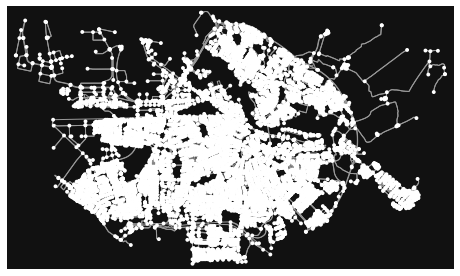

In [2]:
# try which_result=1 or =2 to get polygon boundary or only a centeral point
# network_type will simplify the network
G = ox.graph_from_place('amsterdam, netherlands', which_result=1,  network_type='drive')

G_projected = ox.project_graph(G) # defalut, epsg:4326, uncomment to use local projection crs, e.g., epsg:32630
ox.plot_graph(G)

ox.save_graph_shapefile(G, filepath= 'data/amsterdam')

In [3]:
gdf = gpd.read_file('./data/amsterdam/edges.shp')

In [5]:
gdf.to_file("AMSRoad.geojson", driver='GeoJSON')

In [4]:
gdf.geometry.iloc[0].xy[0]

array('d', [4.8877742, 4.8879185, 4.8882715, 4.8883961])

In [5]:
def splitToSegment(road):
    segments = []
    for i in range(len(road.xy[0])-1):
        segments.append(LineString([(road.xy[0][i], road.xy[1][i]), (road.xy[0][i+1], road.xy[1][i+1])]))
    return segments

In [6]:
segmentList = []

for g in gdf.geometry:
    for s in splitToSegment(g):
        segmentList.append(s)

In [7]:
segmentDF = pd.DataFrame(np.array([segmentList, np.arange(len(segmentList))]).T, columns=['road', 'id'])

<ipython-input-7-c7c66e1d276f>:1: FutureWarning: The input object of type 'LineString' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'LineString', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  segmentDF = pd.DataFrame(np.array([segmentList, np.arange(len(segmentList))]).T, columns=['road', 'id'])
<ipython-input-7-c7c66e1d276f>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  segmentDF = pd.DataFrame(np.array([segmentList, np.arange(len(segmentList))]).T, columns=['road

In [8]:
segmentDF = gpd.GeoDataFrame(segmentDF, geometry = segmentDF.road)

<AxesSubplot:>

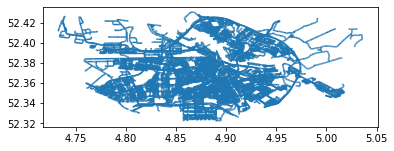

In [9]:
segmentDF.plot()

In [10]:
def cal_angle(street):
    x1, x2 = street.xy[0]
    y1, y2 = street.xy[1]
    if y1 == y2:
        return 90
    else:
        degree = np.degrees(np.arctan(np.abs(y1-y2) / np.abs(x1-x2)))
        if x1 < x2:
            if y1 < y2:
                return 90-degree
            else:
                return 90+degree
        else:
            if y1 < y2:
                return 270 + degree
            else:
                return 270 - degree

In [11]:
segmentDF['angle'] = segmentDF['geometry'].apply(cal_angle)

In [51]:
# segDF_reverse = copy.deepcopy(segmentDF)
# segDF_reverse['angle'] = segDF_reverse['angle'].apply(lambda x: (x+180) % 360)

In [53]:
# segmentDF.head()

,road,id,geometry,angle
0,"LINESTRING (-71.116094 42.384332, -71.1160974 ...",0,"LINESTRING (-71.11609 42.38433, -71.11610 42.3...",357.883510
1,"LINESTRING (-71.1160974 42.384424, -71.1161297...",1,"LINESTRING (-71.11610 42.38442, -71.11613 42.3...",357.338721
2,"LINESTRING (-71.1161297 42.3851189, -71.116132...",2,"LINESTRING (-71.11613 42.38512, -71.11613 42.3...",357.349310
3,"LINESTRING (-71.117555 42.3852766, -71.1174945...",3,"LINESTRING (-71.11755 42.38528, -71.11749 42.3...",93.216545
4,"LINESTRING (-71.11749450000001 42.3852732, -71...",4,"LINESTRING (-71.11749 42.38527, -71.11625 42.3...",93.761564


In [52]:
# segDF_reverse

,road,id,geometry,angle
0,"LINESTRING (-71.116094 42.384332, -71.1160974 ...",0,"LINESTRING (-71.11609 42.38433, -71.11610 42.3...",177.883510
1,"LINESTRING (-71.1160974 42.384424, -71.1161297...",1,"LINESTRING (-71.11610 42.38442, -71.11613 42.3...",177.338721
2,"LINESTRING (-71.1161297 42.3851189, -71.116132...",2,"LINESTRING (-71.11613 42.38512, -71.11613 42.3...",177.349310
3,"LINESTRING (-71.117555 42.3852766, -71.1174945...",3,"LINESTRING (-71.11755 42.38528, -71.11749 42.3...",273.216545
4,"LINESTRING (-71.11749450000001 42.3852732, -71...",4,"LINESTRING (-71.11749 42.38527, -71.11625 42.3...",273.761564
...,...,...,...,...
12406,"LINESTRING (-71.0743282 42.370869, -71.0741833...",12406,"LINESTRING (-71.07433 42.37087, -71.07418 42.3...",201.534581
12407,"LINESTRING (-71.0741833 42.3712362, -71.074156...",12407,"LINESTRING (-71.07418 42.37124, -71.07416 42.3...",201.492501
12408,"LINESTRING (-71.0727136 42.3715539, -71.072670...",12408,"LINESTRING (-71.07271 42.37155, -71.07267 42.3...",219.849400
12409,"LINESTRING (-71.0726707 42.3716053, -71.072236...",12409,"LINESTRING (-71.07267 42.37161, -71.07224 42.3...",220.064629


In [54]:
# segDF = pd.concat([segmentDF, segDF_reverse]).reset_index(drop=True)

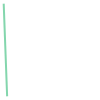

In [58]:
# segDF.geometry.iloc[0]

In [12]:
segmentDF.geometry.iloc[0].xy

(array('d', [4.8877742, 4.8879185]), array('d', [52.3702155, 52.370203]))

In [13]:
segmentDF.head(2)

,road,id,geometry,angle
0,"LINESTRING (4.8877742 52.3702155, 4.8879185 52...",0,"LINESTRING (4.88777 52.37022, 4.88792 52.37020)",94.950893
1,"LINESTRING (4.8879185 52.370203, 4.8882715 52....",1,"LINESTRING (4.88792 52.37020, 4.88827 52.37018)",93.533892


In [14]:
segmentDF.shape

(67320, 4)

In [15]:
segmentDF.drop(columns=['road']).to_file("amsStreetSegment.geojson", driver='GeoJSON')

In [86]:
interval_meters = 0.0005
dfs = []

for idx, row in segmentDF.iterrows():
    g = row.geometry
    angle = row.angle
    street_pts = []
    length = g.length
    
    if length <= interval_meters:
        continue
#         street_pts.append(g.interpolate(length/2))
    else:
        for dist in np.arange(0, length, interval_meters):
            street_pts.append(g.interpolate(dist))
    
    street_pts_df = pd.DataFrame(np.array([[i.x for i in street_pts], [i.y for i in street_pts], np.arange(len(street_pts))]).T, columns=['lon', 'lat', 'id'])
    street_pts_df['angle'] = angle
    dfs.append(street_pts_df)


In [87]:
dataDF = pd.concat(dfs).reset_index(drop=True)
dataDF['id'] = dataDF.index

In [88]:
dataDF.to_pickle('data/request_pts.p', protocol=3)

In [84]:
dataDF.to_csv('data/request_pts.csv')

`python /home/maoransu/software/GSV/GSVdownload_maoran.py /home/maoransu/projects/removeGSV/data/request_pts.p -o /home/maoransu/projects/removeGSV/data -p -t 20 -s 0`

In [89]:
panoids = pd.read_pickle('data/pano_cambridge.p')

In [95]:
panoids_angle = panoids.set_index('id').join(dataDF[['id','angle']].set_index('id'))

In [97]:
panoids_angle_reverse = copy.deepcopy(panoids_angle)
panoids_angle_reverse['angle'] = panoids_angle_reverse['angle'].apply(lambda x: (x+180)%360)

In [ ]:
panos = pd.concat([panoids_angle, panoids_angle_reverse]).reset_index()

In [102]:
panos = panos.rename(columns={'angle':'heading'})

In [106]:
panos['panoid'].shape, panos['heading'].shape

((64958,), (64958,))

In [107]:
panos['id_angle'] = ["{}_{}".format(i,h) for i,h in zip(panos['panoid'], panos['heading'])]

In [108]:
panos

,id,panoid,lat,lon,year,month,heading,id_angle
0,0,KqlMgom41JGKNdtCdZHQqw,42.384394,-71.116117,2019.0,8.0,357.338721,KqlMgom41JGKNdtCdZHQqw_357.33872124704675
1,0,yG-tEVIXQLlv0O5bczV1Sw,42.384362,-71.116141,2018.0,7.0,357.338721,yG-tEVIXQLlv0O5bczV1Sw_357.33872124704675
2,0,uXyq-8HRyilr5DdZsVF4lQ,42.384385,-71.116123,2017.0,10.0,357.338721,uXyq-8HRyilr5DdZsVF4lQ_357.33872124704675
3,0,4Ta8r9kuf3pUygLLhtL1Og,42.384397,-71.116109,2014.0,9.0,357.338721,4Ta8r9kuf3pUygLLhtL1Og_357.33872124704675
4,0,ENPbmLAvNBn--a_f33G5Dw,42.384361,-71.116081,2013.0,9.0,357.338721,ENPbmLAvNBn--a_f33G5Dw_357.33872124704675
...,...,...,...,...,...,...,...,...
64953,3513,Ask-5HBKXFTIsxUzFzkFzw,42.371081,-71.073213,2011.0,8.0,282.042769,Ask-5HBKXFTIsxUzFzkFzw_282.0427692686056
64954,3513,XkgFMKZgiircUE1W124iCA,42.371110,-71.073202,2020.0,11.0,282.042769,XkgFMKZgiircUE1W124iCA_282.0427692686056
64955,3514,KOjvaib0v-iX9bLzcWFV7Q,42.371601,-71.072641,2020.0,11.0,220.064629,KOjvaib0v-iX9bLzcWFV7Q_220.0646292371219
64956,3515,93nn5X9MBsA57YwqhGU1Rg,42.371943,-71.072281,2018.0,10.0,220.064629,93nn5X9MBsA57YwqhGU1Rg_220.0646292371219


In [110]:
panos.to_pickle("data/pano.p", protocol=3)

`python /home/maoransu/software/GSV/GSVdownload_maoran.py /home/maoransu/projects/removeGSV/data/pano.p -o /home/maoransu/projects/removeGSV/data/img -g -t 5 -s 0 -n 30 -i id_angle --mode heading`

In [131]:
panos = pd.read_pickle("data/pano.p")

In [123]:
images = os.listdir('data/img')
id_angles = [i[:-4] for i in images]

In [124]:
panos.id_angle.isin(id_angles).sum()

53512

In [132]:
panos['path'] = panos.id_angle.apply(lambda x: x+'.jpg')

In [135]:
panos = panos[panos['path'].isin(images)].reset_index(drop=True)

In [137]:
panos.to_csv('data/panoIDs.csv')

0

In [140]:
panos = pd.read_csv("data/panoIDs.csv", index_col=0)

In [141]:
panos

,id,panoid,lat,lon,year,month,heading,id_angle,marker,path
0,0,KqlMgom41JGKNdtCdZHQqw,42.384394,-71.116117,2019.0,8.0,357.338721,KqlMgom41JGKNdtCdZHQqw_357.33872124704675,True,KqlMgom41JGKNdtCdZHQqw_357.33872124704675.jpg
1,0,yG-tEVIXQLlv0O5bczV1Sw,42.384362,-71.116141,2018.0,7.0,357.338721,yG-tEVIXQLlv0O5bczV1Sw_357.33872124704675,True,yG-tEVIXQLlv0O5bczV1Sw_357.33872124704675.jpg
2,0,uXyq-8HRyilr5DdZsVF4lQ,42.384385,-71.116123,2017.0,10.0,357.338721,uXyq-8HRyilr5DdZsVF4lQ_357.33872124704675,True,uXyq-8HRyilr5DdZsVF4lQ_357.33872124704675.jpg
3,0,4Ta8r9kuf3pUygLLhtL1Og,42.384397,-71.116109,2014.0,9.0,357.338721,4Ta8r9kuf3pUygLLhtL1Og_357.33872124704675,True,4Ta8r9kuf3pUygLLhtL1Og_357.33872124704675.jpg
4,0,ENPbmLAvNBn--a_f33G5Dw,42.384361,-71.116081,2013.0,9.0,357.338721,ENPbmLAvNBn--a_f33G5Dw_357.33872124704675,True,ENPbmLAvNBn--a_f33G5Dw_357.33872124704675.jpg
...,...,...,...,...,...,...,...,...,...,...
53411,3501,vu7O5gvUb7oljxGAxnPftA,42.372082,-71.072133,2018.0,10.0,113.619767,vu7O5gvUb7oljxGAxnPftA_113.6197673909723,True,vu7O5gvUb7oljxGAxnPftA_113.6197673909723.jpg
53412,3511,FKiZSmqGjp8yJaY5i-0bjQ,42.371271,-71.074110,2014.0,6.0,282.042769,FKiZSmqGjp8yJaY5i-0bjQ_282.0427692686056,True,FKiZSmqGjp8yJaY5i-0bjQ_282.0427692686056.jpg
53413,3512,s4jmM66FBYKJaeRJJRMqNA,42.371168,-71.073630,2014.0,6.0,282.042769,s4jmM66FBYKJaeRJJRMqNA_282.0427692686056,True,s4jmM66FBYKJaeRJJRMqNA_282.0427692686056.jpg
53414,3513,rWwVx1GQHeaXYeoDwHpgIQ,42.371089,-71.073251,2017.0,10.0,282.042769,rWwVx1GQHeaXYeoDwHpgIQ_282.0427692686056,True,rWwVx1GQHeaXYeoDwHpgIQ_282.0427692686056.jpg


In [151]:
panos[panos['id']==0].iloc[:8]

,id,panoid,lat,lon,year,month,heading,id_angle,marker,path
0,0,KqlMgom41JGKNdtCdZHQqw,42.384394,-71.116117,2019.0,8.0,357.338721,KqlMgom41JGKNdtCdZHQqw_357.33872124704675,True,KqlMgom41JGKNdtCdZHQqw_357.33872124704675.jpg
1,0,yG-tEVIXQLlv0O5bczV1Sw,42.384362,-71.116141,2018.0,7.0,357.338721,yG-tEVIXQLlv0O5bczV1Sw_357.33872124704675,True,yG-tEVIXQLlv0O5bczV1Sw_357.33872124704675.jpg
2,0,uXyq-8HRyilr5DdZsVF4lQ,42.384385,-71.116123,2017.0,10.0,357.338721,uXyq-8HRyilr5DdZsVF4lQ_357.33872124704675,True,uXyq-8HRyilr5DdZsVF4lQ_357.33872124704675.jpg
3,0,4Ta8r9kuf3pUygLLhtL1Og,42.384397,-71.116109,2014.0,9.0,357.338721,4Ta8r9kuf3pUygLLhtL1Og_357.33872124704675,True,4Ta8r9kuf3pUygLLhtL1Og_357.33872124704675.jpg
4,0,ENPbmLAvNBn--a_f33G5Dw,42.384361,-71.116081,2013.0,9.0,357.338721,ENPbmLAvNBn--a_f33G5Dw_357.33872124704675,True,ENPbmLAvNBn--a_f33G5Dw_357.33872124704675.jpg
5,0,mnVQmpeR2oRbICFIVgq3dg,42.384426,-71.116090,2011.0,8.0,357.338721,mnVQmpeR2oRbICFIVgq3dg_357.33872124704675,True,mnVQmpeR2oRbICFIVgq3dg_357.33872124704675.jpg
6,0,_O253i5dU2nNhXIDPHdi3w,42.384391,-71.116081,2009.0,10.0,357.338721,_O253i5dU2nNhXIDPHdi3w_357.33872124704675,True,_O253i5dU2nNhXIDPHdi3w_357.33872124704675.jpg
7,0,1kzD5bUBvZTRRap9w7yRHA,42.384391,-71.116122,2020.0,11.0,357.338721,1kzD5bUBvZTRRap9w7yRHA_357.33872124704675,True,1kzD5bUBvZTRRap9w7yRHA_357.33872124704675.jpg


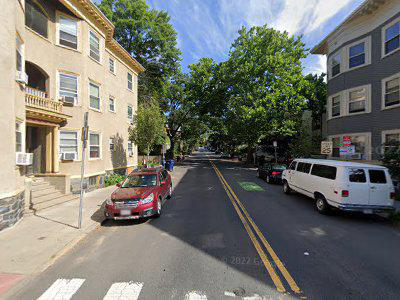

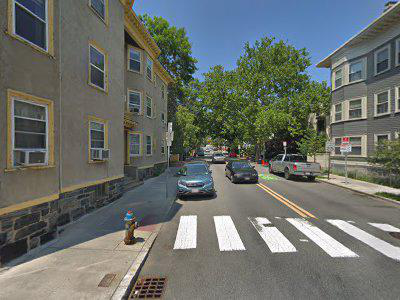

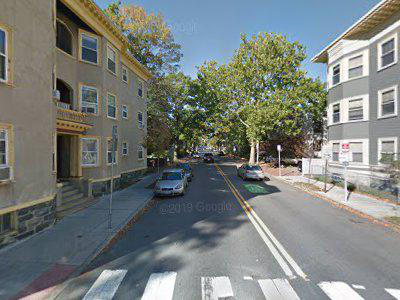

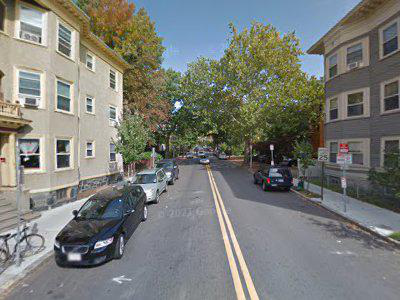

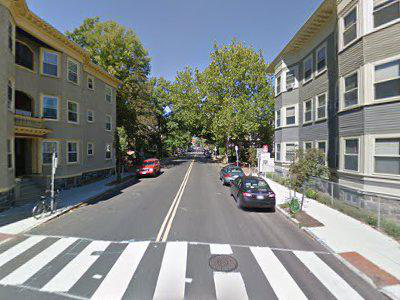

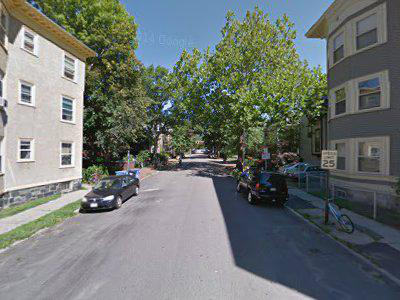

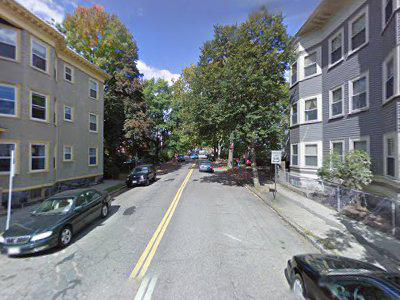

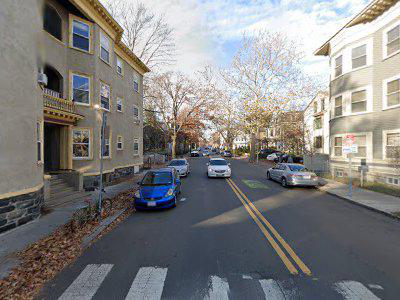

In [150]:
for i in panos[panos['id']==0]['path'].iloc[:8]:
    display(Image.open('data/img/'+i))